In [2]:
import pandas as pd

final_df = pd.read_csv('../data/snyk_and_advisory_with_git_info.csv')

In [4]:
# Function to convert star strings to numbers
def convert_k_to_numeric(val):
    if pd.isna(val):
        return None
    if 'k' in val:
        return float(val.replace('k', '')) * 1000
    return float(val)

# Function to process dependents (split into dependent packages and dependent repos)
def process_dependents(val):
    # print(val)
    if pd.isna(val):
        return None
    if '?' in val:
        return None
    
    val = eval(str(val))
    if val[0] == None:
        return None

    dep_packages, dep_repos = val
    # Convert to numeric after removing commas
    dep_packages = int(dep_packages.replace(',', '')) if dep_packages != '0' else 0
    dep_repos = int(dep_repos.replace(',', '')) if dep_repos != '0' else 0
    return dep_packages

def process_dependencies(val):
    if pd.isna(val):
        return None
    # val = eval(val)
    deps = int(val.replace(',', '')) if val != '0' else 0
    return deps

def process_contributors(val):
    if pd.isna(val):
        return None
    if val[-1] == '+':
        val = val[:-1]
    # val = eval(val)
    contrs = int(val.replace(',', '')) if val != '0' else 0
    return contrs


# process_dependencies('1,200')
# process_dependents(('73,903', '73,903'))
# process_contributors('2,298')
# Apply conversion to Stars column
final_df['Stars'] = final_df['Stars'].apply(convert_k_to_numeric)
final_df['Dependents'] = final_df['Dependents'].apply(process_dependents)
final_df['Dependencies'] = final_df['Dependencies'].apply(process_dependencies)
final_df['Contributors'] = final_df['Contributors'].apply(process_contributors)

# final_df['Dependents_P'] = final_df['Dependents_Pkgs'].apply(process_contributors)
final_df.head()

,ID,Package,CWE,CVE,Date,Platform,Version Range,GitHub URL,Source,Stars,Contributors,Dependencies,Dependents,Dependents_Pkgs,Desciptions,Tags
0,SNYK-DOTNET-MAGICKNETCORE-7856102,magick.net.core,CWE-122,CVE-2023-4863,1 Sep 2024,NuGet,"['[,13.3.0)']",https://github.com/dlemstra/Magick.NET,Snyk,3500.0,38.0,44.0,0.0,NaN,NaN,NaN
1,SNYK-DOTNET-SERILOGENRICHERSCLIENTINFO-7853254,serilog.enrichers.clientinfo,CWE-348,CVE-2024-44930,30 Aug 2024,NuGet,"['[,2.1.0)']",https://github.com/serilog-contrib/serilog-enr...,Snyk,102.0,16.0,15.0,731.0,NaN,NaN,NaN
2,SNYK-DOTNET-RESTSHARP-7853196,restsharp,CWE-113,CVE-2024-45302,30 Aug 2024,NuGet,"['[107.0.0-preview.1,112.0.0)']",https://github.com/restsharp/RestSharp,Snyk,9700.0,271.0,1220.0,73859.0,NaN,NaN,NaN
3,SNYK-DOTNET-BOUNCYCASTLE-7831269,bouncycastle,CWE-835,CVE-2024-30172,26 Aug 2024,NuGet,"['[0,]']",NaN,Snyk,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,SNYK-DOTNET-BOUNCYCASTLECRYPTOGRAPHY-7831268,bouncycastle.cryptography,CWE-835,CVE-2024-30172,26 Aug 2024,NuGet,"['[,2.3.1)']",NaN,Snyk,NaN,NaN,NaN,NaN,NaN,NaN,NaN


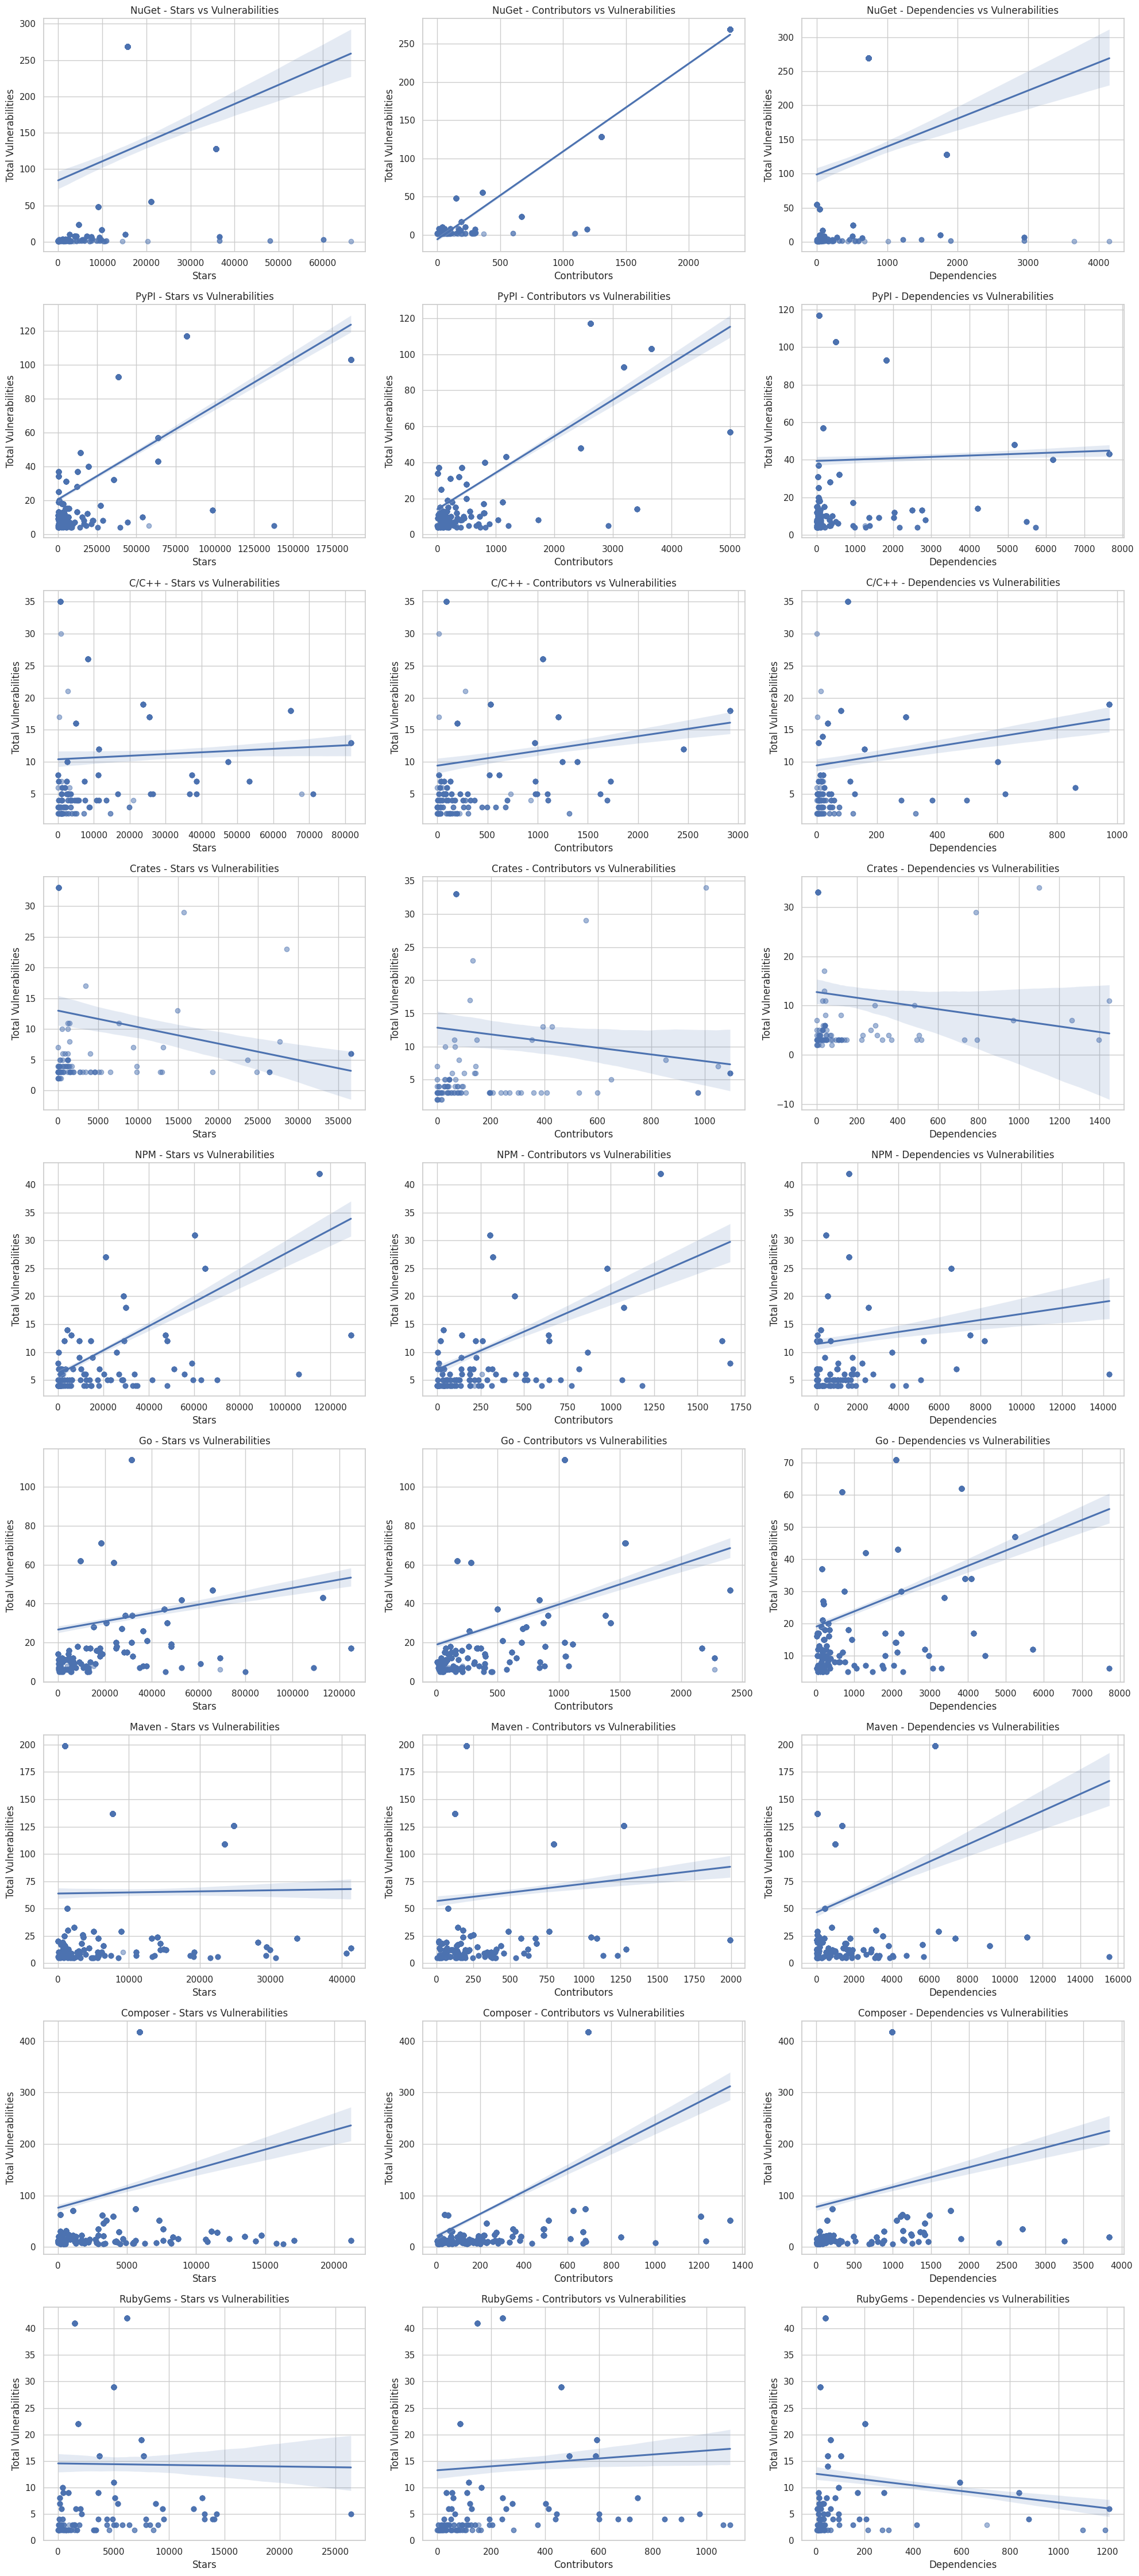

In [7]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = final_df

# Group by GitHub URL and Platform and count total vulnerabilities for each repository
vuln_count = df.groupby(['GitHub URL', 'Platform']).size().reset_index(name='Total_Vulnerabilities')

# Sort by vulnerabilities and get top 100 for each platform
top_100_repos = vuln_count.groupby('Platform').apply(lambda x: x.nlargest(100, 'Total_Vulnerabilities')).reset_index(drop=True)

# Merge top 100 repositories back with the original data
df_top_100 = df.merge(top_100_repos, on=['GitHub URL', 'Platform'])

sns.set(style="whitegrid")

# Function to remove outliers based on IQR
def remove_outliers(df, col):
    Q1 = df[col].quantile(0.1)
    Q3 = df[col].quantile(0.9)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# Define the repository properties to plot against total vulnerabilities
properties = ['Stars', 'Contributors', 'Dependencies']

# Plot scatter plots for each platform and each property
platforms = df_top_100['Platform'].unique()

fig, axes = plt.subplots(len(platforms), len(properties), figsize=(20, len(platforms) * 5))

for i, platform in enumerate(platforms):
    platform_df = df_top_100[df_top_100['Platform'] == platform]
    
    for j, prop in enumerate(properties):
        # Remove outliers for the property
        clean_df = remove_outliers(platform_df, prop)
        
        # Scatter plot with regression line for each property vs Total_Vulnerabilities
        sns.regplot(x=clean_df[prop], y=clean_df['Total_Vulnerabilities'], ax=axes[i, j], scatter_kws={'alpha': 0.5})
        axes[i, j].set_title(f'{platform} - {prop} vs Vulnerabilities')
        axes[i, j].set_xlabel(prop)
        axes[i, j].set_ylabel('Total Vulnerabilities')

plt.tight_layout()
plt.show()
# fig.savefig('top_100_repos_corrolation.pdf')

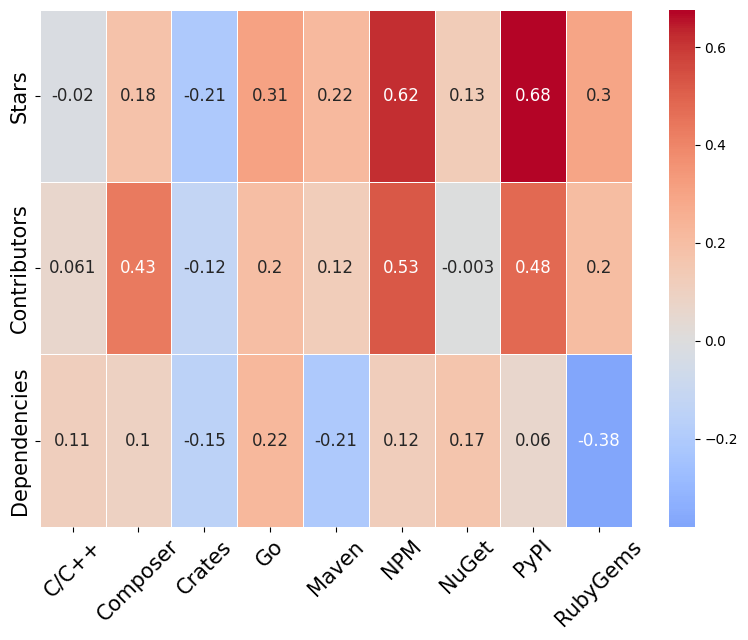

In [6]:

df = final_df

# Group by GitHub URL and Platform and count total vulnerabilities for each repository
vuln_count = df.groupby(['GitHub URL', 'Platform', 'Package']).size().reset_index(name='Total_Vulnerabilities')

# Sort by vulnerabilities and get top 100 for each platform
top_100_repos = vuln_count.groupby('Platform').apply(lambda x: x.nlargest(100, 'Total_Vulnerabilities')).reset_index(drop=True)

# Merge top 100 repositories back with the original data
df_top_100 = df.merge(top_100_repos, on=['GitHub URL', 'Platform'])


# List of properties to calculate correlation for
properties = ['Stars', 'Contributors', 'Dependencies']

# Initialize a dictionary to store correlations
correlation_data = {}

# Sort platforms alphabetically
platforms = sorted(df_top_100['Platform'].unique())

# Loop through each platform and calculate correlations
for platform in platforms:
    platform_df = df_top_100[df_top_100['Platform'] == platform]
    
    # Calculate correlations with Total_Vulnerabilities for the 3 properties
    correlations = {}
    for prop in properties:
        clean_df = remove_outliers(platform_df, prop)
        correlations[prop] = clean_df[['Total_Vulnerabilities', prop]].corr().iloc[0, 1]
    
    correlation_data[platform] = correlations

# Create a DataFrame from the correlation data
correlation_df = pd.DataFrame(correlation_data).T  # Transpose to have platforms as rows

# Plotting the heatmap
fig = plt.figure(figsize=(8, len(platforms)*0.5 + 2))  # Adjust the height based on number of platforms
heatmap = sns.heatmap(correlation_df.T, annot=True, cmap="coolwarm", linewidths=0.5, center=0, annot_kws={"size": 12})

# Increase the size of x and y ticks
heatmap.tick_params(axis='x', labelsize=15)  # X-axis tick size
heatmap.tick_params(axis='y', labelsize=15)  # Y-axis tick size

# Set plot labels and title
# plt.title('Correlation between GitHub Properties and Total Vulnerabilities by Platform')
plt.xlabel('')
plt.ylabel('')

plt.xticks(rotation=45)  # Rotate and align the x-axis labels
# plt.xticks(fontsize=12, rotation=45)  # Increase x-tick size

plt.tight_layout()
plt.show()

# fig.savefig('corrolation_heatmap.pdf')